This post uses a synthetic control design to study whether Texas's prison building boom in 1993 resulted in them incarcerating more prisoners than they would have if their rate of prison building had continued as normal. The analysis will build off the one in the book [Causal Inference: The Mixtable](https://mixtape.scunning.com/), but will make use of techniques from Gelman's [Bayesian workflow](https://arxiv.org/pdf/2011.01808).

As in the *Mixtape* book, we'll express Texas's incarceration rates over time as a mixture of those of other states with comparable poverty, alcoholiosm and incarceration rates in '93. Then, we'll use this mixture of other states to construct a "synthetic" counterfactual Texas which, like the states in the mixture, didn't have a prison building boom after '93. We can compare the difference between the true and synthetic Texas over time. 

In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from torch.distributions import Normal
from gpytorch.likelihoods.noise_models import HomoskedasticNoise
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
texas = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/texas.dta")
texas = texas[texas.state != 'District of Columbia']

Our endogenous variable $y$ will be the black male incarceration rate. I'll use a zscore for ease of training hyperparameters. 

In [3]:
texas['incarceration_rate'] = texas.bmprison / texas.bmpop

In [4]:
texas['incarceration_z'] = texas.groupby('year').incarceration_rate.transform(zscore)

In [5]:
texas['poverty'] = texas['poverty'] / 100

In [6]:
texas = texas.sort_values(["state", "year"])

In [7]:
data = np.reshape(texas[["incarceration_z", "poverty", "alcohol"]].values, (50, 16,-1))

Looking at the data shows a pretty sizeable increase in Texas's incarceration rate after '93 compared to other states, which lends credence to the hypothesis.

In [8]:
years = pd.unique(texas.year)

In [9]:
states = pd.unique(texas.state)

In [10]:
texix = list(states).index("Texas")

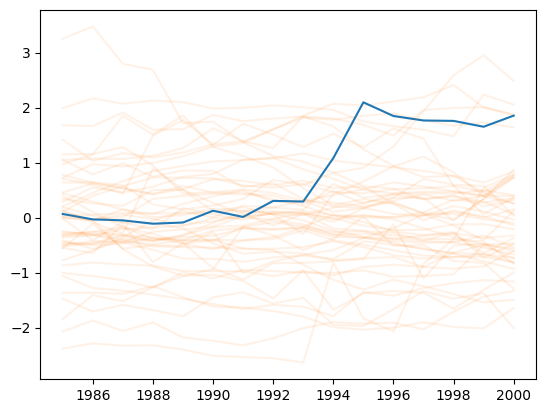

In [11]:
for ix, r in enumerate(data):
    if ix == texix:
        plt.plot(years, r[:,0], color="C0")
    else:
        plt.plot(years, r[:,0], color="C1" , alpha=0.1)

To construct our synthetic version of Texas, we'll fit a Gaussian process model relating state characteristics in 1993 (incarceration rate, poverty and alcoholism levels) to incarceration rates for other years. Then we'll apply the fitted model to Texas's characeristics to predict the counterfactual incarceration rate.

In [12]:
X = torch.from_numpy(data[:,7,:]).float()

In [13]:
Y = torch.from_numpy(data[:,:7,0]).float()

In [14]:
class SynthControlModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=3))
        self.noise = HomoskedasticNoise()

    def forward(self, x):
        covar_x = self.noise(x) + self.covar_module(x)
        return MultivariateNormal(torch.zeros(covar_x.shape[0]), covar_x)

In [15]:
model = SynthControlModel()

The following code fits the noise and lengthscale parameters by maximum likelihood estimation.

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=0.1)

In [17]:
for i in range(200):
    opt.zero_grad()
    loss = -model(X).log_prob(Y.T).sum()
    loss.backward()
    if i % 20 == 0:
        print(loss.item())
    opt.step()

390.9499206542969
221.37319946289062
212.59107971191406
211.1005401611328
210.900634765625
210.87908935546875
210.87689208984375
210.87579345703125
210.87570190429688
210.87567138671875


The fitted noise and lengthscales seem reasonable.

In [18]:
model.noise.noise.detach()

tensor([0.0906])

In [19]:
model.covar_module.base_kernel.lengthscale.detach()

tensor([[1.6206, 0.9185, 1.6307]])

Prediction with a Gaussian process is just a matter of cranking through the Gaussian conditioning equations. I'm avoiding gpytorch's high level interface here, as we'll need the additional flexibility that comes from doing this manually. 

In [20]:
def predict(X, test_X, Y):
    with torch.no_grad():
        prior_x = model(X)
        prior_t = model(test_X)
        X_tk = model.covar_module.forward(test_X, X)
        mu = X_tk @ torch.linalg.solve(prior_x.covariance_matrix, Y)
        S = prior_t.covariance_matrix - X_tk @ torch.linalg.solve(prior_x.covariance_matrix, X_tk.T)
        return MultivariateNormal(mu.T, S)

Here, then, is our counterfactual prediction for Texas's incarceration rate based on the training data from all the other states. There's a lot of uncertainty shown by the blue shading, but we can guess the general trend.

In [21]:
non_texas = np.delete(np.arange(50), texix)

In [22]:
X_no_texas = torch.from_numpy(data[non_texas, 7]).float()

In [23]:
y_no_texas = torch.from_numpy(data[non_texas,:,0]).float()

In [24]:
X_texas = torch.from_numpy(data[None,texix, 7]).float()

In [25]:
predictions = predict(X_no_texas, X_texas, y_no_texas)
lower, upper = predictions.confidence_region()

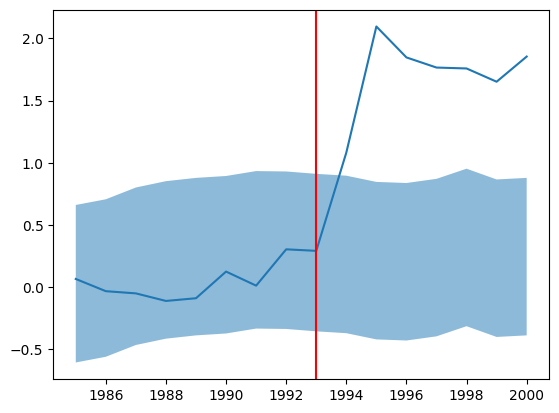

In [26]:
plt.fill_between(years, lower[:,0].numpy(), upper[:,0].numpy(), alpha=0.5)
plt.plot(years, data[texix,:,0]);
plt.axvline(x=1993, c='red');

Texas fits the model just fine pre-1993, but quickly deviates after its building boom. We can show just how atypical this lack of fit is using a randomization test. We'll collect the log likelihoods of each state's post '93 observations in the posterior predictive we obtained from fitting on the other states. The fraction of states with likelihoods below that of Texas gives us a p-value: the probability of seeing a fit as bad as Texas's if the treatment effect were zero.

In [27]:
post_93 = torch.from_numpy(data[:,8:,0]).float()

In [28]:
state_probs = []
for i in range(50):
    ixs = np.delete(np.arange(50), i)
    post_prob = predict(X[ixs], X[i:i+1], post_93[ixs]).log_prob(post_93[i:i+1].T)
    state_probs.append(post_prob.sum())
state_probs = torch.stack(state_probs, axis=0)

In [29]:
(list(torch.argsort(state_probs)).index(texix) + 1) / len(state_probs)

0.02

If we're okay with a 2% false positive rate, we can reject the null hypothesis that the treatment effect is zero. 

We can examine the contribution of top states towards our synthetic version of texas as follows:

In [30]:
def state_contrib(model):
    X_kk = model.covar_module.forward(X_no_texas, X_no_texas)
    X_kt = model.covar_module.forward(X_no_texas, X_texas)
    return torch.linalg.solve(X_kk, X_kt)[:,0]

In [31]:
cs = state_contrib(model)

In [32]:
ixs = torch.argsort(-cs)[:3]

In [33]:
list(zip(states[non_texas][ixs], cs[ixs].detach()))

[('South Dakota', tensor(2.1369)),
 ('Virginia', tensor(1.6360)),
 ('Missouri', tensor(1.5237))]

In [34]:
similar_states = data[non_texas][ixs,:,0]

We can overlay the trajectory of the similar states themselves below:

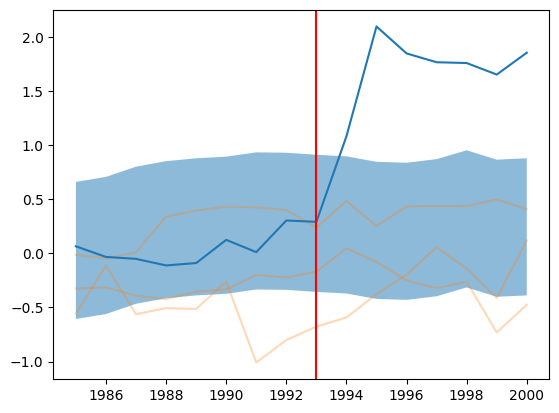

In [35]:
for r in similar_states:
    plt.plot(years, r, color="C1", alpha=0.3)
plt.fill_between(years, lower[:,0].numpy(), upper[:,0].numpy(), alpha=0.5)
plt.plot(years, data[texix,:,0]);
plt.axvline(x=1993, c='red');

Just because the Gaussian process model fits Texas worse than any other state, however, doesn't mean it's actually fitting the other states all that well. 

To see how well the model fits the other states, we can do some leave-one-out cross validation. Specifically, we can check that the observed incarceration distribution for past and future years is similar to that of samples from the leave-one-out posterior predictive distribution. Below, the orange line shows the observed distribution of incarceration rate z scores, while the blue lines are leave-one-out posterior predictive samples.

In [36]:
results = []
for i in range(49):
    ixs = np.delete(np.arange(49), i)
    post = predict(X_no_texas[ixs], X_no_texas[i:i+1], y_no_texas[ixs]).sample(torch.Size([20]))
    results.append(post)
results = torch.concat(results, axis=-1)

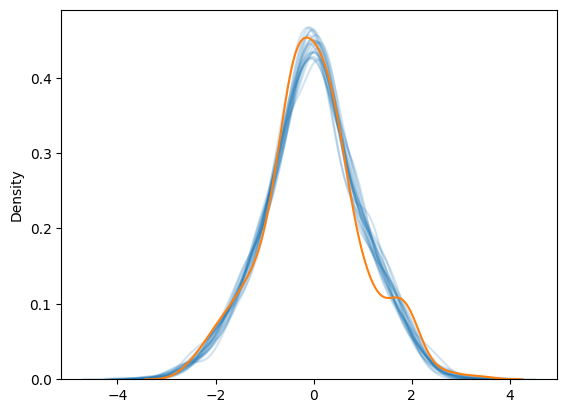

In [37]:
for i in range(20):
    sns.kdeplot(results[i].ravel(), color='C0', alpha=0.2)
sns.kdeplot(y_no_texas.ravel(), color='C1');

The fit is pretty good, but the wiggle on the right side of the orange plot indicates that our data gives somewhat higher incarceration rates than the predictive posterior would suggest. Let's break this down by year.

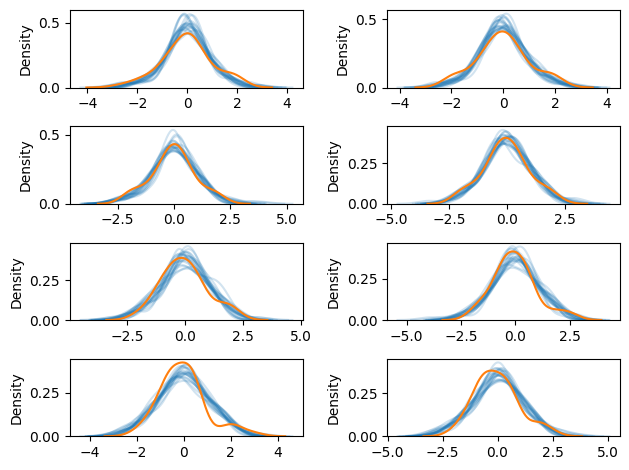

In [38]:
fig, axs = plt.subplots(4, 2)
for (dist, obs, ax) in zip(results.permute((1, 0, 2)), y_no_texas[:,8:].T, axs.ravel()):
    for i in range(20):
        sns.kdeplot(dist[i], color='C0', alpha=0.2, ax=ax)
    sns.kdeplot(obs, color='C1', ax=ax);
plt.tight_layout()

In earlier years, everything seems okay. But by '98, that extra little hump starts appearing on the right. While other states weren't increasing their rates as fast as Texas was, it does seem like the model isn't quite describing them correctly. 

We can validate this lack of fit further by checking probability-integral-transform values. The fraction of the leave-one-out posterior predictive distribution below each observation would be uniform under perfect caliration.

In [39]:
def to_univariate(post):
    return Normal(post.mean, post.covariance_matrix.ravel())

In [40]:
results = []
for i in range(49):
    ixs = np.delete(np.arange(49), i)
    post = predict(X_no_texas[ixs], X_no_texas[i:i+1], y_no_texas[ixs])
    results.append(to_univariate(post).cdf(y_no_texas[i:i+1]))
results = torch.concat(results, axis=-1)

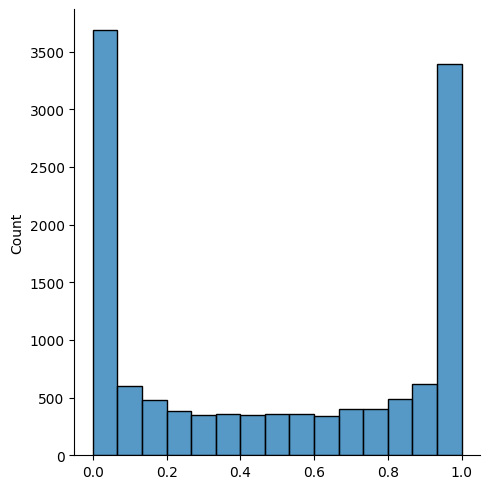

In [41]:
sns.displot(results.ravel());

The posterior predictive distributions seem to be quite under-dispersed relative to the observations. We need a better model! But I'll leave that to a future post. 